1.Import Libraries and Define Helper Functions

In [1]:
!python --version
!pip install tensorflow==2.18.0
!pip install matplotlib==3.9.2
!pip install numpy==1.26.4
!pip install keras==3.6.0
!pip install joblib==1.4.2

# Import necessary libraries for image processing, data parsing, and model training
import xml.etree.ElementTree as ET  # For parsing XML files
import cv2  # OpenCV for image processing
import numpy as np  # For numerical operations on arrays
import matplotlib.pyplot as plt  # For plotting images and graphs
import tensorflow as tf
from keras._tf_keras.keras.applications import MobileNetV2  # Pre-trained MobileNetV2 model for transfer learning
from keras._tf_keras.keras.models import Model  # For building and training the neural network model
from keras._tf_keras.keras.layers import Dense, Dropout, GlobalAveragePooling2D  # Layers for customizing the model
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator  # For data augmentation
from keras._tf_keras.keras.optimizers import Adam  # Optimizer for model training
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # For creating confusion matrix
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras.utils import to_categorical
import os
import random
import joblib
import hashlib


Python 3.10.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 608.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstal

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2.LOAD IMAGE AND PRASE XML DATA

In [3]:
import os
import cv2
import json
import numpy as np

# Path to the processed data directory
processed_data_dir = '/content/drive/MyDrive/processed_data'

# Define the input size for the images (e.g., 224x224 for MobileNetV2)
input_size = (224,224)

# Prepare an empty list to hold the processed data
all_data_processed = []

# Loop through each label folder and load the data
for label_folder in os.listdir(processed_data_dir):
    folder_path = os.path.join(processed_data_dir, label_folder)

    # Only process if it's a directory (for labels)
    if os.path.isdir(folder_path):
        print(f"Processing label folder: {label_folder}")  # Debug: Current label folder

        for json_file in os.listdir(folder_path):
            if json_file.endswith('.json'):
                # Load the corresponding JSON file
                json_path = os.path.join(folder_path, json_file)
                with open(json_path, 'r') as file:
                    annotation_data = json.load(file)

                # Load the corresponding image file
                image_path = os.path.join(folder_path, json_file.replace('.json', '.png'))
                image = cv2.imread(image_path)
                original_size = image.shape[:2]  # Original size (height, width)
                image = cv2.resize(image, input_size)  # Resize the image to the required input size
                image = image.astype(np.float32) / 255.0  # Normalize the image to [0, 1] and use float32

                # Extract data from JSON
                label = annotation_data['label']
                bbox = annotation_data['bbox']
                keypoints_left = annotation_data['keypoints_left']
                keypoints_right = annotation_data['keypoints_right']

                # Rescale the bounding box
                x_scale = input_size[1] / original_size[1]
                y_scale = input_size[0] / original_size[0]
                bbox_resized = {
                    "left": {
                        "xmin": int(bbox["left"]["xmin"] * x_scale),
                        "ymin": int(bbox["left"]["ymin"] * y_scale),
                        "xmax": int(bbox["left"]["xmax"] * x_scale),
                        "ymax": int(bbox["left"]["ymax"] * y_scale)
                    },
                    "right": {
                        "xmin": int(bbox["right"]["xmin"] * x_scale),
                        "ymin": int(bbox["right"]["ymin"] * y_scale),
                        "xmax": int(bbox["right"]["xmax"] * x_scale),
                        "ymax": int(bbox["right"]["ymax"] * y_scale)
                    }
                }

                # Append the data to the all_data list in the same structure as your original all_data
                all_data_processed.append((image, label, bbox_resized, keypoints_left, keypoints_right))

# Convert lists to arrays
X = np.array([item[0] for item in all_data_processed], dtype=np.float32)
y = np.array([item[1] for item in all_data_processed])

# Print confirmation of the total number of items in all_data
print(f"Total data entries created: {len(all_data_processed)}")


Processing label folder: 0
Processing label folder: 9
Processing label folder: 6
Processing label folder: 4
Processing label folder: 2
Processing label folder: 5
Processing label folder: 7
Processing label folder: 3
Processing label folder: 1
Processing label folder: 8
Total data entries created: 2498


3.Overlay Annotations (Bounding Box, Label, and Keypoints)

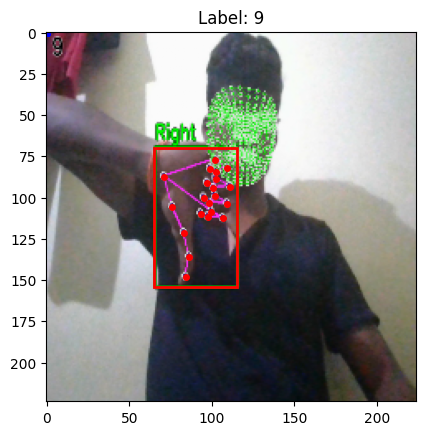

In [4]:
# ( PRIMARY )

import matplotlib.pyplot as plt
import random
import cv2

# Select a random sample from the parsed data
sample_image, sample_label, sample_bbox, sample_keypoints_left, sample_keypoints_right = random.choice(all_data_processed)

# If the image is of type float64, convert it to uint8((FOR JSON ))
if sample_image.dtype == np.float64:
    print(sample_image.dtype)
    sample_image = (sample_image * 255).astype(np.uint8)

# Display the randomly selected sample with annotations
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title(f"Label: {sample_label}")

# Draw left and right hand bounding boxes if present
xmin, ymin, xmax, ymax = sample_bbox['left']['xmin'], sample_bbox['left']['ymin'], sample_bbox['left']['xmax'], sample_bbox['left']['ymax']
plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='blue', facecolor='none'))
xmin, ymin, xmax, ymax = sample_bbox['right']['xmin'], sample_bbox['right']['ymin'], sample_bbox['right']['xmax'], sample_bbox['right']['ymax']
plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none'))

# Plot left hand keypoints if they exist
for (x, y) in sample_keypoints_left:
    plt.plot(x * sample_image.shape[1], y * sample_image.shape[0], 'bo',markersize=4)  # Blue dots for left hand keypoints

# Plot right hand keypoints if they exist
for (x, y) in sample_keypoints_right:
    plt.plot(x * sample_image.shape[1], y * sample_image.shape[0], 'ro',markersize=4)  # Red dots for right hand keypoints


plt.show()




4.Prepare Dataset and Data Generators

Pixel values before normalization (min, max): 0.0 1.0
Pixel values after normalization (min, max): 0.003921569 0.9939519


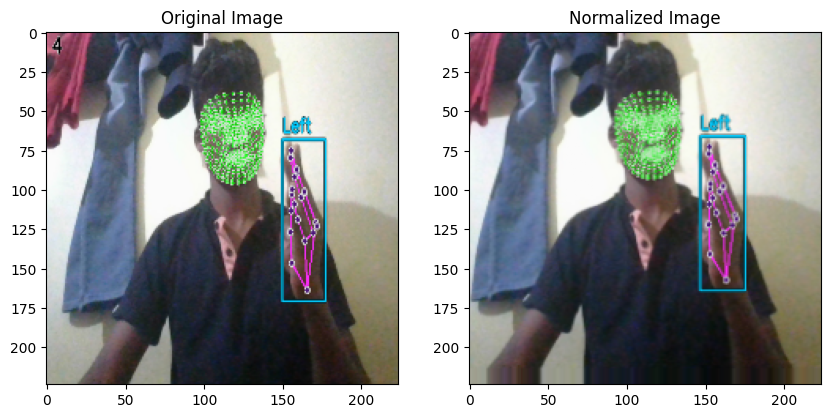

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
import random
import cv2

# Initialize ImageDataGenerator with only rescaling (normalization)
datagen = ImageDataGenerator(
    #rescale=1./255,  # Normalize pixel values to [0, 1]
    #rotation_range=5,  # Rotate images by up to 10 degrees
    width_shift_range=0.05,  # Shift images horizontally by up to 10% of width
    height_shift_range=0.05,  # Shift images vertically by up to 10% of height
    shear_range=0.05,  # Shear transformation
    zoom_range=0.05,  # Random zoom
    horizontal_flip=False,  # Randomly flip images horizontally
    fill_mode='nearest'
)

# Load a sample image
sample_image = random.choice(all_data_processed)[0]

# Reshape the image to add an extra dimension
sample_image = np.expand_dims(sample_image, axis=0)

# Print pixel values before normalization
print("Pixel values before normalization (min, max):", sample_image.min(), sample_image.max())

# Generate a batch of normalized images
normalized_images = datagen.flow(sample_image, batch_size=1)

# Get the normalized image from the generator
normalized_image = next(normalized_images)[0]

# Print pixel values after normalization
print("Pixel values after normalization (min, max):", normalized_image.min(), normalized_image.max())

# Display the original and normalized images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
# Convert the image to uint8 before displaying
plt.imshow(cv2.cvtColor( (sample_image[0] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(normalized_image, cv2.COLOR_BGR2RGB))
plt.title('Normalized Image')

plt.show()

5. prepare data for training

In [7]:
import pickle

# Path to your labelmapping.pkl file
file_path = '/content/drive/MyDrive/label_mapping.pkl'

# Open the file in read binary ('rb') mode
with open(file_path, 'rb') as file:
    # Load the data from the file using pickle.load()
    label_mapping = pickle.load(file)

# Now you can access the label mapping data
print(label_mapping)  # Print the contents of the label mapping
# Or access specific elements using keys if it's a dictionary
# For example, if it's a dictionary mapping integers to labels:
# print(label_mapping[0])  # Print the label corresponding to key 0


# Assuming all_data is already populated with (image, label, bbox, keypoints_left, keypoints_right, keypoints_face)
X = []
y = []
for image, label, bbox, keypoints_left, keypoints_right in all_data_processed:
    X.append(image)
    y.append(label_mapping[label])

X = np.array(X)
y = np.array(y)

# One-hot encode the labels
#y = to_categorical(y, num_classes=len(label_mapping))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert your labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)


{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


6.Define and Compile the Model

In [8]:
# Load the base MobileNetV2 model without the top classification layer
base_model = MobileNetV2(input_shape=(224,224, 3), include_top=False, weights='imagenet')

# Fine-tuning: Unfreeze some layers in the base model for better feature extraction
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x) # As i am using this flatten is not needed
x = Dense(512, activation='relu')(x)  # Increased units for more complex patterns
x = Dropout(0.7)(x)  # Increased dropout for stronger regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.7)(x)

# Final output layer
output = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with a lower learning rate and a different optimizer (optional)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary to verify the architecture
#model.summary()

# Make sure your data is properly shaped
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape: (1998, 224, 224, 3)
y_train shape: (1998, 10)
X_val shape: (500, 224, 224, 3)
y_val shape: (500, 10)


6.Train the Model

In [9]:
from keras._tf_keras.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Define the ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # Filepath to save the best model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Only save the model if the validation loss improves
    mode='min'  # Minimize validation loss
)

# Train the model using the data generator and the callbacks
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],  # Include both callbacks
    verbose=1
)


# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)

# Print the test accuracy
print(f"Test accuracy: {accuracy}")

# Save model
model.save("/content/drive/MyDrive/models/hand_gesture_model2.h5")
model.save("/content/drive/MyDrive/models/hand_gesture_keras2.keras")




/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.0950 - loss: 3.3037 - val_accuracy: 0.1100 - val_loss: 2.3665
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.1231 - loss: 2.9937 - val_accuracy: 0.1600 - val_loss: 2.2921
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.1410 - loss: 2.7241 - val_accuracy: 0.2000 - val_loss: 2.2297
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.1460 - loss: 2.5429 - val_accuracy: 0.2200 - val_loss: 2.1777
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.1712 - loss: 2.4370 - val_accuracy: 0.2480 - val_loss: 2.1269
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.1654 - loss: 2.2903 - val_accuracy: 0.3060 - val_loss: 2.0701
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.2040 - loss: 2.2377 - val_accuracy: 0.3420 - val_loss: 2.0170
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.2464 - loss: 2.1613 - val_accuracy: 0.3900 - val_loss

Test accuracy: 0.8339999914169312


7.Plot Accuracy, Loss, and Confusion Matrix

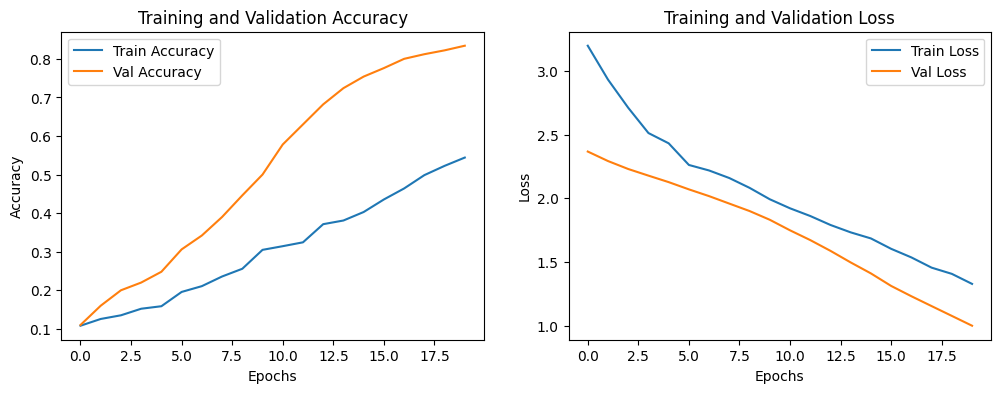

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step


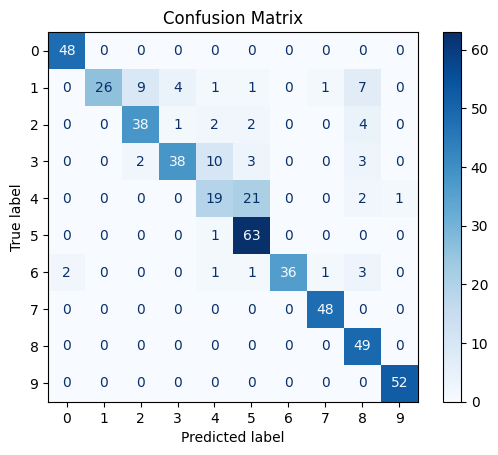

In [10]:

# Plot training accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

# Generate confusion matrix for the validation set
y_pred = model.predict(X_val)  # Replace with actual validation data
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)  # Replace with actual validation labels

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# #!pip install mediapipe
# from IPython.display import display, Javascript
# from google.colab.output import eval_js
# from base64 import b64decode
# import cv2
# import mediapipe as mp
# import numpy as np
# import os
# import xml.etree.ElementTree as ET
# import time
# from tensorflow.keras.models import load_model
# import pickle

# # Initialize Mediapipe modules for hand and face detection
# mp_hands = mp.solutions.hands
# mp_face_mesh = mp.solutions.face_mesh
# mp_drawing = mp.solutions.drawing_utils

# # Constants
# IMG_SIZE = (640, 640)
# MARGIN = 15
# MODEL_PATH = '/content/hand_gesture_model.h5'  # Replace with the path to your .h5 model
# LABEL_MAP_PATH = '/content/label_mapping.pkl'  # Replace with the path to your label map file

# # Load the trained model and label map
# model = load_model(MODEL_PATH)
# with open(LABEL_MAP_PATH, 'rb') as f:
#     label_map = pickle.load(f)

# # Function to preprocess each frame for prediction (resize to model input size)
# def preprocess_frame(frame):
#     frame_resized = cv2.resize(frame, IMG_SIZE)
#     frame_normalized = frame_resized / 255.0  # Normalize pixel values
#     frame_expanded = np.expand_dims(frame_normalized, axis=0)  # Add batch dimension
#     return frame_expanded

# # Function to predict hand gesture using the model
# def predict_gesture(frame):
#     processed_frame = preprocess_frame(frame)
#     predictions = model.predict(processed_frame)
#     predicted_class = np.argmax(predictions, axis=1)[0]
#     gesture_label = label_map[predicted_class]
#     confidence = predictions[0][predicted_class]
#     return gesture_label, confidence

# # Start capturing from webcam
# cap = cv2.VideoCapture(0)
# with mp_hands.Hands(max_num_hands=2) as hands:
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Convert frame to RGB for Mediapipe processing
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         hand_results = hands.process(frame_rgb)

#         # Draw hand landmarks
#         if hand_results.multi_hand_landmarks:
#             for hand_landmarks in hand_results.multi_hand_landmarks:
#                 mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

#         # Make a prediction if a hand is detected
#         if hand_results.multi_hand_landmarks:
#             # Predict gesture
#             gesture_label, confidence = predict_gesture(frame)

#             # Display predicted label and confidence on the frame
#             label_text = f"Gesture: {gesture_label} ({confidence:.2f})"
#             cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, lineType=cv2.LINE_AA)

#         # Display the frame
#         cv2.imshow('Hand Gesture Recognition', frame)
#         if not ret:
#           print("Ignoring empty camera frame.")
#           break
#         # Press 'q' to exit
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

# cap.release()
# cv2.destroyAllWindows()
